In [4]:
import pandas as pd
from pyspark.sql import SparkSession
from google.cloud import storage
import os
import io
from datetime import datetime
from tqdm import tqdm

In [5]:
spark = SparkSession.builder.appName('bigdata_taxi').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])

#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.stage.maxConsecutiveAttempts', '10'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.eventLog.enabled', 'true'),
 ('spark.ui.proxyBase', '/proxy/application_1677949503645_0002'),
 ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_URI_BASES',
  'http://hub-hub-msca-bdp-dphub-student-dharmi-m:8088/proxy/application_1677949503645_0002'),
 ('spark.dataproc.sql.joinConditionReorder.enabled', 'true'),
 ('spark.driver.host',
  'hub-hub-msca-bdp-dphub-student-dharmi-m.c.msca-bdp-student-ap.internal'),
 ('spark.eventLog.dir',
  'gs://dataproc-temp-us-central1-635155370842-uzamlpgc/aba12bd3-fa8f-4236-b864-ec6647bc1c39/spark-job-history'),
 ('spark.dataproc.sql.local.rank.pushdown.enabled', 'true'),
 ('spark.yarn.unmanagedAM.enabled', 'true'),
 ('spark.sql.autoBroadcastJoinThreshold', '43m'),
 ('spark.ui.filters',
  'org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter'),
 ('spark.metrics.namespace',
  'app_name:${spark.app.name}.app_id:${spar

In [6]:
bucket_name = 'msca-bdp-student-gcs'
storage_client = storage.Client()
from_date = datetime.strptime('2012-01-01','%Y-%m-%d')
till_date = datetime.strptime('2022-12-31','%Y-%m-%d')
folder_name = 'Group8_Project_Data'

req_cols = ['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee']

for blob in tqdm(storage_client.list_blobs(bucket_name, prefix = folder_name)):
    if str(blob.name).split(".")[-1] == 'parquet':
        file_month = ''.join(list(filter(str.isdigit, blob.name))[1:])
        if datetime.strptime(file_month, '%Y%m') >= from_date and datetime.strptime(file_month, '%Y%m') <= till_date:
            if datetime.strptime(file_month, '%Y%m') == from_date:
                df = spark.read.parquet(f'gs://{bucket_name}/{blob.name}', inferSchema=True, header=True)
                df = df.select(*req_cols)
            else:
                df_month = spark.read.parquet(f'gs://{bucket_name}/{blob.name}', inferSchema=True, header=True)
                df = df.union(df_month.select(*req_cols))
                
location_mapping = spark.read.csv(f'gs://{bucket_name}/{folder_name}/tlc_trip_record_yellow_taxi/taxi_zone_lookup.csv', inferSchema = True, header = True)

170it [01:09,  2.44it/s]                                                        


# Treat Missing Values

In [7]:
from pyspark.sql.functions import isnan, when, count, col, round
# df.select([(round(count(when(df[c].isNull(), c))/count(df[c])*100,2)).alias(c) for c in df.columns]).show()

In [8]:
#Create another dataframe to process
df2 = df.alias('df2')

In [9]:
df2 = df2.fillna(0, subset=['airport_fee'])
df2 = df2.na.drop("any")
#df2.select([(count(when(df2[c].isNull(), c))/count(df2[c])).alias(c) for c in df2.columns]).show()

# Treat Outlier

In [10]:
double_cols = [item[0] for item in df2.dtypes if item[1] == 'double']
for double_col in double_cols:
    df2 = df2.filter(df2[double_col]>0)
#df2.describe().show()

# Feature Engineering

In [11]:
new_column_name_list = list(map(lambda x: 'PU' + x , location_mapping.columns))
location_mapping_pu = location_mapping.toDF(*new_column_name_list)

df2 = df2.join(location_mapping_pu,df2.PULocationID == location_mapping_pu.PULocationID,"left").drop('PULocationID','LocationID')

In [12]:
new_column_name_list = list(map(lambda x: 'DO' + x , location_mapping.columns))
location_mapping_do = location_mapping.toDF(*new_column_name_list)

df2 = df2.join(location_mapping_do,df2.DOLocationID == location_mapping_do.DOLocationID,"left").drop('DOLocationID','LocationID','PULocationID')
# df2.show(2)

In [13]:
from pyspark.sql.functions import *

def extract_date_info_spark(df, date_column, prefix):
    date_df = df.withColumn(prefix + "_" + "datetime", to_timestamp(col(date_column))) \
                .withColumn(prefix + "_" + "year", year(col(date_column))) \
                .withColumn(prefix + "_" + "month", month(col(date_column))) \
                .withColumn(prefix + "_" + "day", dayofmonth(col(date_column))) \
                .withColumn(prefix + "_" + "hour", hour(col(date_column))) \
                .withColumn(prefix + "_" + "day_of_week", dayofweek(col(date_column))) \
                .withColumn(prefix + "_" + "day_of_year", dayofyear(col(date_column))) \
                .withColumn(prefix + "_" + "week_of_year", weekofyear(col(date_column))) \
                .withColumn(prefix + "_" + "is_month_start", (dayofmonth(col(date_column)) == lit(1))) \
                .withColumn(prefix + "_" + "is_year_start", (dayofyear(col(date_column)) == lit(1))) \
                .withColumn(prefix + "_" + "is_year_end", (dayofyear(col(date_column)) == lit(365)))
    
    pickup_columns = [c for c in date_df.columns if c.startswith(prefix)]
    date_df = date_df.select(*pickup_columns)
    
    for c in date_df.columns:
        if c != prefix + "_" + "datetime":
            date_df = date_df.withColumn(c,col(c).cast("double"))
                            
    return date_df

In [14]:
from pyspark.sql.functions import year, month, dayofmonth, hour, minute,concat,lit
from pyspark.sql.types import StringType
from pyspark.ml.feature import StringIndexer,OneHotEncoder

df2 = df2.filter((to_date(df2.tpep_pickup_datetime) >= from_date) & (to_date(df2.tpep_pickup_datetime) <= till_date))
df2 = df2.withColumn("VendorID", df2["VendorID"].cast(StringType()))
df2 = df2.withColumn("RateCodeID", df2["RateCodeID"].cast(StringType()))

df2 = df2.drop('payment_type','total_amount')

df2 = df2.withColumn('duration', unix_timestamp(col('tpep_dropoff_datetime')) - unix_timestamp(col('tpep_pickup_datetime')))
df2 = df2.withColumn('duration', round(col('duration') / 60, 2))
                     
pickup_date_info_df2 = extract_date_info_spark(df2, 'tpep_pickup_datetime', 'pickup')
# dropoff_date_info_df2 = extract_date_info_spark(df2, 'tpep_dropoff_datetime', 'dropoff')

df2 = df2.join(pickup_date_info_df2, df2.tpep_pickup_datetime == pickup_date_info_df2.pickup_datetime, how = 'left')
#df2 = df2.join(dropoff_date_info_df2, df2.tpep_dropoff_datetime == dropoff_date_info_df2.dropoff_datetime, how = 'left')

df2 = df2.drop(*['tpep_pickup_datetime','pickup_datetime','tpep_dropoff_datetime'])
df2 = df2.drop(*['extra','mta_tax','tip_amount','tolls_amount','improvement_surcharge','congestion_surcharge','airport_fee'])
                     
df2 = df2.withColumn("season",
                    when((df2.pickup_month >= 3) & (df2.pickup_month <= 5), "Spring")
                    .when((df2.pickup_month >= 6) & (df2.pickup_month <= 8), "Summer")
                    .when((df2.pickup_month >= 9) & (df2.pickup_month <= 10), "Fall")
                    .when((df2.pickup_month >= 11) | (df2.pickup_month <= 2), "Winter")
                    .otherwise("Unknown"))
                     
# keeping only the rows where duration is not equal to 0
df2 = df2.filter(col("duration") != 0)

In [15]:
df2.printSchema()

root
 |-- VendorID: string (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RateCodeID: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- PUBorough: string (nullable = true)
 |-- PUZone: string (nullable = true)
 |-- PUservice_zone: string (nullable = true)
 |-- DOBorough: string (nullable = true)
 |-- DOZone: string (nullable = true)
 |-- DOservice_zone: string (nullable = true)
 |-- duration: double (nullable = true)
 |-- pickup_year: double (nullable = true)
 |-- pickup_month: double (nullable = true)
 |-- pickup_day: double (nullable = true)
 |-- pickup_hour: double (nullable = true)
 |-- pickup_day_of_week: double (nullable = true)
 |-- pickup_day_of_year: double (nullable = true)
 |-- pickup_week_of_year: double (nullable = true)
 |-- pickup_is_month_start: double (nullable = true)
 |-- pickup_is_year_start: double (nullable = true)
 |-- picku

# Model Fitting

In [16]:
%%time
from pyspark.sql.functions import concat, lit, udf
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder

#convert relevant categorical into one hot encoded
onehot_list = ['VendorID','RateCodeID','store_and_fwd_flag','PUBorough','DOBorough','PUservice_zone','DOservice_zone','PUZone','DOZone','season']
inputs = []
encoder = []
for column in onehot_list:
    df2 = df2.withColumn(column, concat(column, lit('_'+column)))
    input_ = StringIndexer(inputCol = column, outputCol = column + 'Idx').setHandleInvalid("skip")
    inputs.append(input_)

encoder = OneHotEncoder(inputCols = [input_.getOutputCol() for input_ in inputs], outputCols = [column+'_vec' for column in onehot_list])

#run it through a pipeline
pipeline = Pipeline(stages=inputs+[encoder])
encodedData = pipeline.fit(df2).transform(df2)

# encodedData.show(5)

23/03/04 17:40:58 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/03/04 17:41:04 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/03/04 17:43:05 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1831.8 KiB
23/03/04 17:43:17 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1829.0 KiB
23/03/04 17:43:38 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.5 MiB
23/03/04 17:43:43 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/03/04 17:45:19 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2002.4 KiB
23/03/04 17:45:30 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1999.6 KiB
23/03/04 17:45:50 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large t

CPU times: user 3.2 s, sys: 587 ms, total: 3.79 s
Wall time: 19min 8s


In [17]:
cols_to_drop = onehot_list+[input_.getOutputCol() for input_ in inputs]
encodedData = encodedData.drop(*cols_to_drop)
encodedData.printSchema()

root
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- duration: double (nullable = true)
 |-- pickup_year: double (nullable = true)
 |-- pickup_month: double (nullable = true)
 |-- pickup_day: double (nullable = true)
 |-- pickup_hour: double (nullable = true)
 |-- pickup_day_of_week: double (nullable = true)
 |-- pickup_day_of_year: double (nullable = true)
 |-- pickup_week_of_year: double (nullable = true)
 |-- pickup_is_month_start: double (nullable = true)
 |-- pickup_is_year_start: double (nullable = true)
 |-- pickup_is_year_end: double (nullable = true)
 |-- VendorID_vec: vector (nullable = true)
 |-- RateCodeID_vec: vector (nullable = true)
 |-- store_and_fwd_flag_vec: vector (nullable = true)
 |-- PUBorough_vec: vector (nullable = true)
 |-- DOBorough_vec: vector (nullable = true)
 |-- PUservice_zone_vec: vector (nullable = true)
 |-- DOservice_zone_vec: vector (nullable = true)
 |-- PUZ

In [18]:
#gather feature vector and identify features
assembler = VectorAssembler(inputCols = encodedData.drop('fare_amount').columns, \
                            outputCol = 'features')

encodedData = assembler.transform(encodedData)
encodedData.printSchema()

root
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- duration: double (nullable = true)
 |-- pickup_year: double (nullable = true)
 |-- pickup_month: double (nullable = true)
 |-- pickup_day: double (nullable = true)
 |-- pickup_hour: double (nullable = true)
 |-- pickup_day_of_week: double (nullable = true)
 |-- pickup_day_of_year: double (nullable = true)
 |-- pickup_week_of_year: double (nullable = true)
 |-- pickup_is_month_start: double (nullable = true)
 |-- pickup_is_year_start: double (nullable = true)
 |-- pickup_is_year_end: double (nullable = true)
 |-- VendorID_vec: vector (nullable = true)
 |-- RateCodeID_vec: vector (nullable = true)
 |-- store_and_fwd_flag_vec: vector (nullable = true)
 |-- PUBorough_vec: vector (nullable = true)
 |-- DOBorough_vec: vector (nullable = true)
 |-- PUservice_zone_vec: vector (nullable = true)
 |-- DOservice_zone_vec: vector (nullable = true)
 |-- PUZ

In [19]:
train_df = encodedData.filter((encodedData.pickup_year <= 2022) & (encodedData.pickup_month <= 10))
test_df = encodedData.filter((encodedData.pickup_year == 2022) & (encodedData.pickup_month >= 10))

In [20]:
%%time
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

lr = LinearRegression(featuresCol = 'features', labelCol='fare_amount')
lrm = lr.fit(train_df)

#model summary
print("Training Summary:")
print(f"RMSE: {lrm.summary.rootMeanSquaredError}")
print(f"r2: {lrm.summary.r2}")

print("-"*100)
print("Testing Summary:")
# Make predictions.
predictions = lrm.transform(test_df)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"RMSE on test data: {rmse}")

23/03/04 17:59:58 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/03/04 18:00:05 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/03/04 18:01:15 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/03/04 18:01:20 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/03/04 18:02:12 WARN org.apache.spark.ml.util.Instrumentation: [5a14973c] regParam is zero, which might cause numerical instability and overfitting.
23/03/04 18:02:12 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1462.9 KiB
23/03/04 18:02:17 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1463.9 KiB
23/03/04 18:02:18 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/03/04 18:02:18 WARN com.github

Training Summary:
RMSE: 3.828175692517535
r2: 0.8854432107311475
----------------------------------------------------------------------------------------------------
Testing Summary:


23/03/04 18:03:54 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/03/04 18:04:00 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/03/04 18:04:55 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1472.8 KiB
23/03/04 18:04:58 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1473.9 KiB


RMSE on test data: 3.9093371725682173
CPU times: user 851 ms, sys: 151 ms, total: 1 s
Wall time: 5min 15s


In [ ]:
%%time
from pyspark.ml.regression import RandomForestRegressor
import matplotlib.pyplot as plt

rf = RandomForestRegressor(featuresCol = 'features', labelCol='fare_amount')
model = rf.fit(train_df)

print("Training Summary:")
predictions = model.transform(train_df)

evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol='fare_amount', predictionCol='prediction', metricName='r2')
rmse = evaluator.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)
print(f"RMSE = {rmse}")
print(f'R-squared = {r2}')

print("-"*100)

# Make predictions.
print("Testing Summary:")
predictions = model.transform(test_df)

evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol='fare_amount', predictionCol='prediction', metricName='r2')
rmse = evaluator.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)
print(f"RMSE = {rmse}")
print(f'R-squared = {r2}')

23/03/04 18:05:17 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/03/04 18:05:24 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/03/04 18:06:15 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1460.9 KiB
23/03/04 18:06:15 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1461.0 KiB
23/03/04 18:06:18 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1466.2 KiB
23/03/04 18:06:21 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1485.2 KiB
23/03/04 18:06:26 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1501.5 KiB
23/03/04 18:06:27 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1531.0 KiB
23/03/04 18:06:28 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting l

Training Summary:


23/03/04 18:06:48 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/03/04 18:06:53 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/03/04 18:07:45 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1466.1 KiB
23/03/04 18:07:48 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1467.2 KiB
23/03/04 18:08:05 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/03/04 18:08:10 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/03/04 18:09:05 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1466.1 KiB
23/03/04 18:09:09 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1467.2 KiB


RMSE = 1.8761697708252425
R-squared = 0.9724842484847744
----------------------------------------------------------------------------------------------------
Testing Summary:


23/03/04 18:09:24 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/03/04 18:09:31 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/03/04 18:10:23 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1466.1 KiB
23/03/04 18:10:26 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1467.2 KiB
23/03/04 18:10:42 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/03/04 18:10:48 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/03/04 18:11:41 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1466.1 KiB


RMSE = 1.8689515283923461
R-squared = 0.971869678081209
CPU times: user 3.37 s, sys: 256 ms, total: 3.63 s
Wall time: 6min 45s


23/03/04 18:11:43 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1467.2 KiB


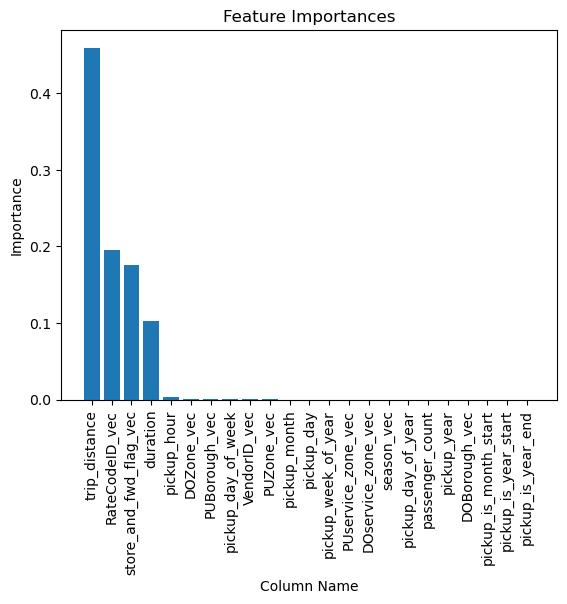

In [ ]:
# Get the feature importances from the model
importances = model.featureImportances
column_names = train_df.columns

# create a list of (column name, importance) tuples
importances = list(zip(train_df.drop(*['fare_amount','features']).columns, model.featureImportances))

# sort the list by importance, in descending order
importances.sort(key=lambda x: x[1], reverse=True)

# extract the column names and importances as separate lists
names, values = zip(*importances)

# create a bar plot of the importances
plt.bar(names, values)

# set the plot title and axis labels
plt.title('Feature Importances')
plt.xlabel('Column Name')
plt.ylabel('Importance')

# rotate the x-axis labels to avoid overlapping
plt.xticks(rotation=90)

# display the plot
plt.show()


In [ ]:
%%time
from pyspark.ml.regression import GBTRegressor

# create a gradient-boosted tree regressor
gbt = GBTRegressor(featuresCol='features', labelCol='fare_amount')

# fit the model to the training data
model = gbt.fit(train_df)

print("Training Summary:")
predictions = model.transform(train_df)

evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol='fare_amount', predictionCol='prediction', metricName='r2')
rmse = evaluator.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)
print(f"RMSE = {rmse}")
print(f'R-squared = {r2}')

print("-"*100)

# Make predictions.
print("Testing Summary:")
predictions = model.transform(test_df)

evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol='fare_amount', predictionCol='prediction', metricName='r2')
rmse = evaluator.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)
print(f"RMSE = {rmse}")
print(f'R-squared = {r2}')

23/03/04 18:12:01 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/03/04 18:12:07 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/03/04 18:13:17 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/03/04 18:13:23 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/03/04 18:14:15 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1460.9 KiB
23/03/04 18:14:15 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1461.0 KiB
23/03/04 18:14:19 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1466.2 KiB
23/03/04 18:14:22 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1475.7 KiB
23/03/04 18:14:24 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large t

Training Summary:


23/03/04 18:15:21 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/03/04 18:15:26 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/03/04 18:16:18 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1466.2 KiB
23/03/04 18:16:21 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1467.3 KiB
23/03/04 18:16:39 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/03/04 18:16:44 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/03/04 18:17:36 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1466.2 KiB
23/03/04 18:17:39 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1467.3 KiB


RMSE = 1.425241417396404
R-squared = 0.9841213352597992
----------------------------------------------------------------------------------------------------
Testing Summary:


23/03/04 18:17:56 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/03/04 18:18:01 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/03/04 18:18:53 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1466.2 KiB
23/03/04 18:18:55 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1467.3 KiB
23/03/04 18:19:10 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/03/04 18:19:17 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/03/04 18:20:06 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1466.2 KiB


RMSE = 1.4059501661703238
R-squared = 0.9840809010961628
CPU times: user 1.39 s, sys: 274 ms, total: 1.66 s
Wall time: 8min 24s


23/03/04 18:20:09 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1467.3 KiB
